# A Regression Analysis Demonstration of Chainer Neural Network Library

Let's go a little further than [SimpleChainer](SimpleChainer.ipynb) and fit a neural network to a function.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I
from mpl_toolkits.mplot3d import Axes3D

In [73]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [48]:
def loadtemphum(fname='temphum.txt', dtype=np.float32, newformat=False):
    from datetime import datetime
    arr = []
    x = []
    y1, y2 = [], []
    # First, load the data
    with open(fname) as f:
        text = f.readlines()
    # split delimited columns into strings 
    for line in text:
        values = line.split("\t")
        arr.append(values)
        x.append(datetime.strptime(values[0], '%Y/%m/%d %H:%M:%S' if newformat else '%a %b %d %H:%M:%S %Y').timestamp())
        y1.append(float(values[1]))
        y2.append(float(values[2]))
    def c(x): return np.array(x[::50],dtype=dtype).reshape((-1,1))
    return (c(x) - min(x)) / (max(x) - min(x)) * 2 - 1, np.concatenate([c(y1), c(y2)], 1)

Main training loop

In [76]:
epoch = 20000
batchsize = 4

#trainx = np.arange(-1,1,0.05, dtype=np.float32).reshape((40,1))
#trainy = np.array(np.sin(np.pi*trainx), dtype=np.float32)
#trainy = np.array(trainx < 0,dtype=np.float32)
trainx, trainy = loadtemphum()
train = chainer.datasets.TupleDataset(trainx, trainy)

test = chainer.datasets.TupleDataset(trainx, trainy)

model = Regressor(trainy.shape[1], 512)

model.zerograds()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
loss_hist = []

for i in range(epoch):
    loss = F.mean_squared_error(model(trainx), trainy)
    loss_hist.append(loss.data)
    if i % 1000 == 0:
        print(i, 'loss', loss.data)
    #optimizer.weight_decay(0.005)
    optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)

chainer.serializers.save_npz("result/regression.model", model)

0 loss 553.3871459960938
1000 loss 0.6569586992263794
2000 loss 0.4480891227722168
3000 loss 0.42430174350738525
4000 loss 0.4008260667324066
5000 loss 0.36999306082725525
6000 loss 0.3246780335903168
7000 loss 0.26577937602996826
8000 loss 0.2115282565355301
9000 loss 0.17044450342655182
10000 loss 0.12924812734127045
11000 loss 0.10432807356119156
12000 loss 0.09145664423704147
13000 loss 0.0835823193192482
14000 loss 0.07849320024251938
15000 loss 0.07355000823736191
16000 loss 0.06997380405664444
17000 loss 0.06667200475931168
18000 loss 0.06394469738006592
19000 loss 0.06137833371758461


loss: 0.05933818221092224
data points:  48


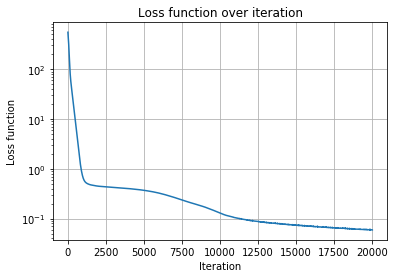

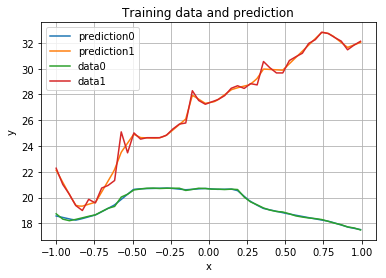

In [81]:

fig, ax = plt.subplots()
ax.semilogy(loss_hist)
ax.grid()
ax.set_title('Loss function over iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss function')

print("loss: {}".format(loss.data))
print("data points: ", len(trainx))
fig, ax = plt.subplots()
# Get fine grained regular grid to plot interpolated points too
px = np.linspace(min(trainx), max(trainx), len(trainx)*10).reshape((-1,1))
ax.plot(px, model(px).data)
ax.plot(trainx, trainy)
ax.legend(['prediction{}'.format(i) for i in range(trainy.shape[1])] + ['data{}'.format(i) for i in range(trainy.shape[1])])
ax.grid()
ax.set_title('Training data and prediction')
ax.set_xlabel('x')
ax.set_ylabel('y')

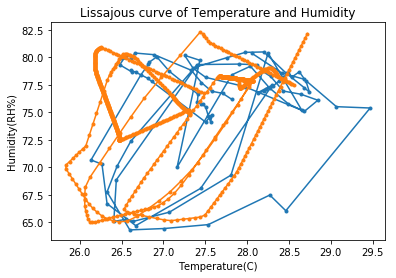

In [119]:
fig, ax = plt.subplots()
ax.plot(trainy[:,0], trainy[:,1], '.-')
ax.plot(model(px).data[:,0], model(px).data[:,1], '.-')
ax.set_title('Lissajous curve of Temperature and Humidity')
ax.set_xlabel('Temperature(C)')
ax.set_ylabel('Humidity(RH%)')

In [76]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

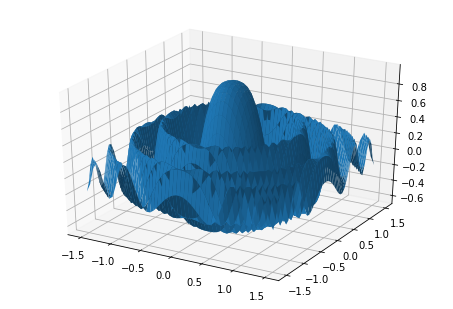

In [70]:
x = np.linspace(-1.5, 1.5, 50)
y = np.linspace(-1.5, 1.5, 50)
X, Y = np.meshgrid(x, y)
X, Y = X.astype(np.float32), Y.astype(np.float32)
def wellfun(x,y):
    r = (x ** 2 + y ** 2)
    return (np.cos(2 * np.pi * r) / (1 + r))
well = wellfun(X,Y).astype(np.float32)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y,well)

In [132]:
def run_train(trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0, regularize=0.0001):
    from time import clock
    start = clock()
    last_report = start
    model = Regressor2(trainy.shape[1], 256)

    model.zerograds()

    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
    loss_hist = []

    for i in range(epoch):
        loss = F.mean_squared_error(model(trainx), trainy)
        loss_hist.append(loss.data)
        if i % report_period == 0:
            if last_report + report_period_seconds < clock():
                ups = i / (clock() - start)
                eta = (epoch - i) / ups if ups != 0 else 0
                etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                last_report = clock()
        #optimizer.weight_decay(0.005)
        optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)

    return model, loss_hist

In [133]:
trainx = np.vstack((X.flat, Y.flat)).T
trainy = np.array(well.flat)[np.newaxis].T
model, loss_hist = run_train(trainx, trainy, epoch=5000, report_period=100, report_period_seconds=5, regularize=0.00001)

100 loss 0.1219881922006607 , ups: 18.51 , eta: 4:24.67
200 loss 0.08147352188825607 , ups: 18.28 , eta: 4:22.63
300 loss 0.06297219544649124 , ups: 18.38 , eta: 4:15.78
400 loss 0.0461476631462574 , ups: 18.43 , eta: 4:09.54
500 loss 0.04201005399227142 , ups: 18.52 , eta: 4:02.96
600 loss 0.03357226401567459 , ups: 18.53 , eta: 3:57.39
700 loss 0.02972789853811264 , ups: 18.57 , eta: 3:51.58
800 loss 0.02813774347305298 , ups: 18.61 , eta: 3:45.73
900 loss 0.02758629061281681 , ups: 18.62 , eta: 3:40.20
1000 loss 0.027298197150230408 , ups: 18.61 , eta: 3:34.90
1100 loss 0.025782419368624687 , ups: 18.62 , eta: 3:29.46
1200 loss 0.023630615323781967 , ups: 18.64 , eta: 3:23.89
1300 loss 0.02191510982811451 , ups: 18.62 , eta: 3:18.67
1400 loss 0.01847691461443901 , ups: 18.59 , eta: 3:13.63
1500 loss 0.01709659770131111 , ups: 18.55 , eta: 3:08.67
1600 loss 0.015410838648676872 , ups: 18.41 , eta: 3:04.67
1700 loss 0.014738814905285835 , ups: 18.18 , eta: 3:01.52
1800 loss 0.01386099

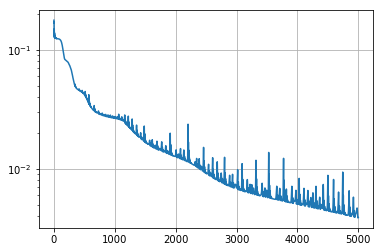

In [134]:
plt.semilogy(loss_hist)
plt.grid()

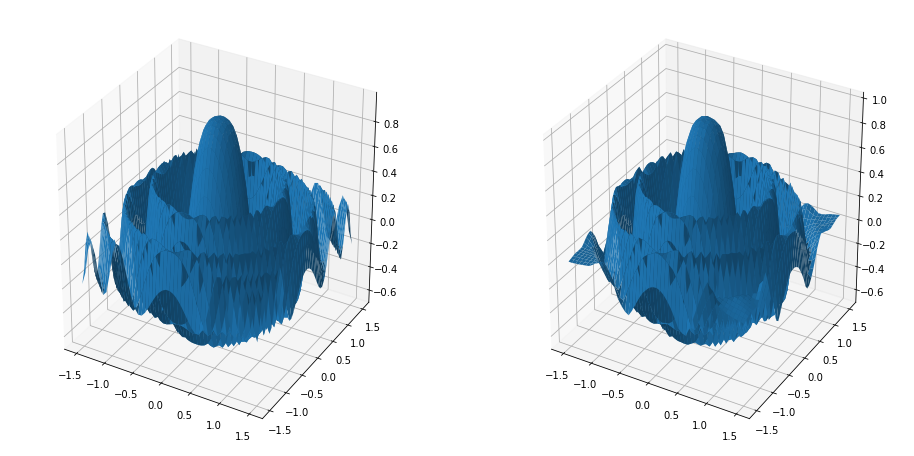

In [135]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,well)

#ax = Axes3D(fig)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X,Y,model(trainx).data.reshape(X.shape))
#ax.plot_surface(X,Y,well)

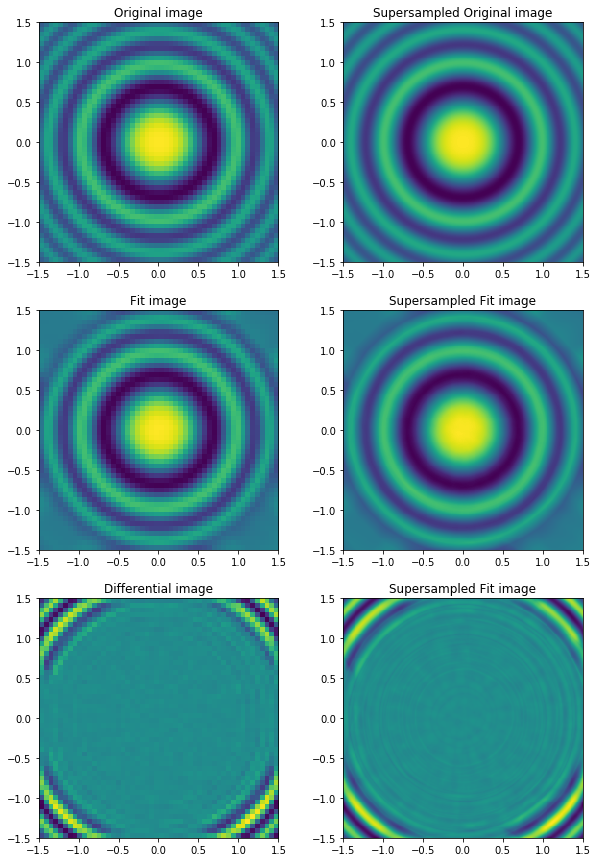

In [136]:
upX, upY = np.meshgrid(np.linspace(min(x),max(x),len(x)*5), np.linspace(min(y),max(y),len(y)*5))
upX, upY = upX.astype(np.float32), upY.astype(np.float32)
upx = np.vstack((upX.flat, upY.flat)).T

fig, axs = plt.subplots(3,2,figsize=(10,15))

axs[0,0].imshow(well,extent=(min(x), max(x), min(y), max(y)))
axs[0,0].set_title('Original image')
axs[1,0].imshow(model(trainx).data.reshape(X.shape),extent=(min(x), max(x), min(y), max(y)))
axs[1,0].set_title('Fit image')
axs[2,0].imshow(well - model(trainx).data.reshape(X.shape),extent=(min(x), max(x), min(y), max(y)))
axs[2,0].set_title('Differential image')
axs[0,1].imshow(wellfun(upX,upY),extent=(min(x), max(x), min(y), max(y)))
axs[0,1].set_title('Supersampled Original image')
axs[1,1].imshow(model(upx).data.reshape(upX.shape),extent=(min(x), max(x), min(y), max(y)))
axs[1,1].set_title('Supersampled Fit image')
axs[2,1].imshow(wellfun(upX,upY) - model(upx).data.reshape(upX.shape),extent=(min(x), max(x), min(y), max(y)))
axs[2,1].set_title('Supersampled Fit image')
